# What is Paper Replicating?

It's no secret machine learning is advancing fast.

Many of these advances get published in machine learning research papers.

And the goal of paper replicating is to replicate these advances with code so you can use the techniques for your own problem.

For example, let's say a new model architecture gets released that performs better than any other architecture before on various benchmarks, wouldn't it be nice to try that architecture on your own problems?

# What we're going to cover?

we're going to be replicating the machine learning research paper An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale (ViT paper) with PyTorch.

The Transformer neural network architecture was originally introduced in the machine learning research paper Attention is all you need.

And the original Transformer architecture was designed to work on one-dimensional (1D) sequences of text.

A Transformer architecture is generally considered to be any neural network that uses the attention mechanism) as its primary learning layer. Similar to a how a convolutional neural network (CNN) uses convolutions as its primary learning layer.

Like the name suggests, the Vision Transformer (ViT) architecture was designed to adapt the original Transformer architecture to vision problem(s) (classification being the first and since many others have followed).

The original Vision Transformer has been through several iterations over the past couple of years, however, we're going to focus on replicating the original, otherwise known as the "vanilla Vision Transformer". Because if you can recreate the original, you can adapt to the others.

# 0. Getting setup

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.2.1+cpu
torchvision version: 0.17.1+cpu


In [3]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular_05.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular_05.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# 1. Get the data

In [5]:
from pathlib import Path
# Setup directory paths to train and test images
image_path = Path("datasets/pizza_steak_sushi")

train_dir = image_path / "train"
test_dir = image_path / "test"

# 2. Create Dataset and DataLoader

pada table 3 di paper ViT. training resolutionnya ialah 224 (height=224, width=224)
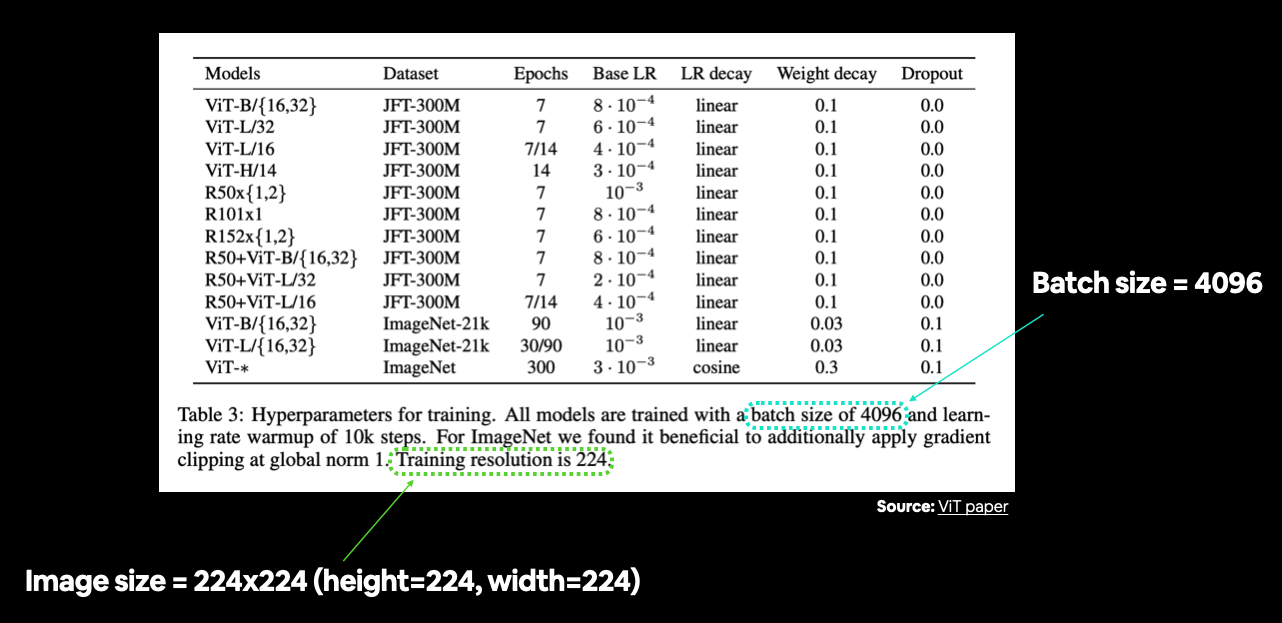
Anda akan sering menemukan berbagai pengaturan hyperparameter yang tercantum dalam tabel. Dalam kasus ini, kita masih menyiapkan data, jadi, yang kita perhatikan terutama adalah, ukuran gambar dan ukuran batch. Sumber: Tabel 3 di kertas ViT.

Jadi, kita akan memastikan transformasi kita mengubah ukuran gambar dengan tepat.

### 2.1 prepare tranforms for images
karna kita membangun model dari awal (tanpa tranfer learning), kita akan melakukan transformasi seperti biasa

In [7]:
# create image size
IMAGE_SIZE = 224

# create transform pipeline manually
manual_transforms = transforms.Compose([
  transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
  transforms.ToTensor()
])
manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

### 2.2 turn image into dataloader
Makalah ViT menyatakan penggunaan ukuran batch 4096 yang merupakan 128x ukuran ukuran batch yang selama ini kami gunakan (32).

Namun, kami akan tetap menggunakan ukuran batch 32.

Mengapa?

Karena beberapa perangkat keras (termasuk tingkat gratis dari Google Colab) mungkin tidak dapat menangani ukuran batch 4096.

Memiliki ukuran batch 4096 berarti 4096 gambar harus masuk ke dalam memori GPU pada satu waktu.

Hal ini dapat berjalan dengan baik ketika Anda memiliki perangkat keras untuk menanganinya seperti yang sering dilakukan oleh tim peneliti dari Google, tetapi ketika Anda menggunakan satu GPU (seperti menggunakan Google Colab), memastikan segala sesuatunya berjalan dengan ukuran batch yang lebih kecil terlebih dahulu adalah ide yang bagus.

> Kami menggunakan parameter `pin_memory = True` dalam fungsi `create_dataloaders ()` untuk mempercepat komputasi. `pin_memory = True` menghindari penyalinan memori yang tidak perlu antara memori CPU dan memori GPU dengan cara "menyematkan" contoh-contoh yang sudah dilihat sebelumnya. Meskipun manfaat dari hal ini mungkin akan terlihat pada ukuran dataset yang lebih besar (dataset FoodVision Mini kami cukup kecil). Namun, pengaturan `pin_memory = True` tidak selalu meningkatkan kinerja (ini adalah salah satu skenario kami dalam pembelajaran mesin di mana beberapa hal kadang-kadang berhasil dan tidak di waktu lain), jadi yang terbaik adalah bereksperimen, bereksperimen, bereksperimen

In [8]:
# Set the batch size
BATCH_SIZE = 32  # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,  # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x17c4c029050>,
 ['pizza', 'steak', 'sushi'])

### 2.3 visualize a single image

In [9]:
# get batch of images
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

(-0.5, 223.5, 223.5, -0.5)

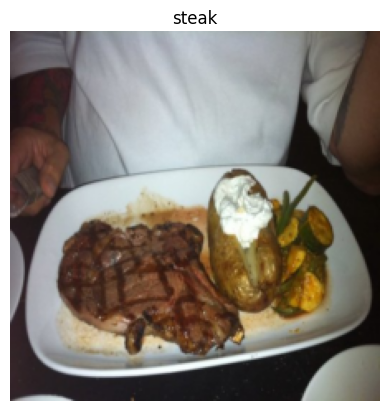

In [12]:
# rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

# 3. Replicating ViT Paper: an overview

kita akan mereplikasi ViT Paper untuk permasalahan kita, FoodVision mini.

jadi **input model** ialah: gambar pizza, steak dan sushi.

dan **output model** ialah: prediksi label dari pizza, steak dan sushi.

pertanyaannya adalah, bagaimana kita beralih dari input ke output yang diinginkan?

### 3.1 inputs and outputs, layers and blocks

ViT adalah deep learning neural network architecture.

dan setiap arsitektur neural network pada umumnya terdiri dari lapisan-lapisan (**layers**).

kumpulan lapisan sering disebut sebagai **block**.

dan menumpukkan banyak blok bersama-sama adalah keseluruhan dari arstekturnya.

Sebuah layer menerima input (katakanlah sebuah tensor gambar), lalu melakukan beberapa fungsi diatas/setelahnya (misalnya apa yang ada di metothod `forward()` layer) dan kemudian mengembalikan sebuah output.

jadi, jika **single layer** menerima input dan memberikan output. maka kumpulan layer atau **block** juga menerima input dan memberikan output.

mari buat hal ini konkrit:
  1. **Layer** - Menerima input, menjalankan fungsi diatasnya dan memberikan output.
  2. **Block** - kumpulan lapisan (**Layer**), menerima input, melakukan serangkaian fungsi diatasnya dan memberikan output.
  3. **Architecture (model)** - kumpulan **Block**, menerima input, melakukan serangkaian fungsi diatasnya dan memberikan output.

konsep inilah yang akan kita gunakan untuk mereplikasi paper ViT.

Kita akan mengambil lapisan demi lapisan, block demi block, fungsi demi fungsi yang akan menyatukan potongan-potongan puzzle seperti Lego untuk mendapatkan arsitektur keseluruhan yang kita inginkan. soalnya klo melihat keseluruhan paper ViT sekaligus bisa menjadi sangat menakutkan wkwk.

jadi untuk pemahaman yang lebih baik, kita akan memecahnya menjadi beberapa bagian. dimulai dengan input dan output dari satu lapisan hingga input dan output dari keseluruhan model.
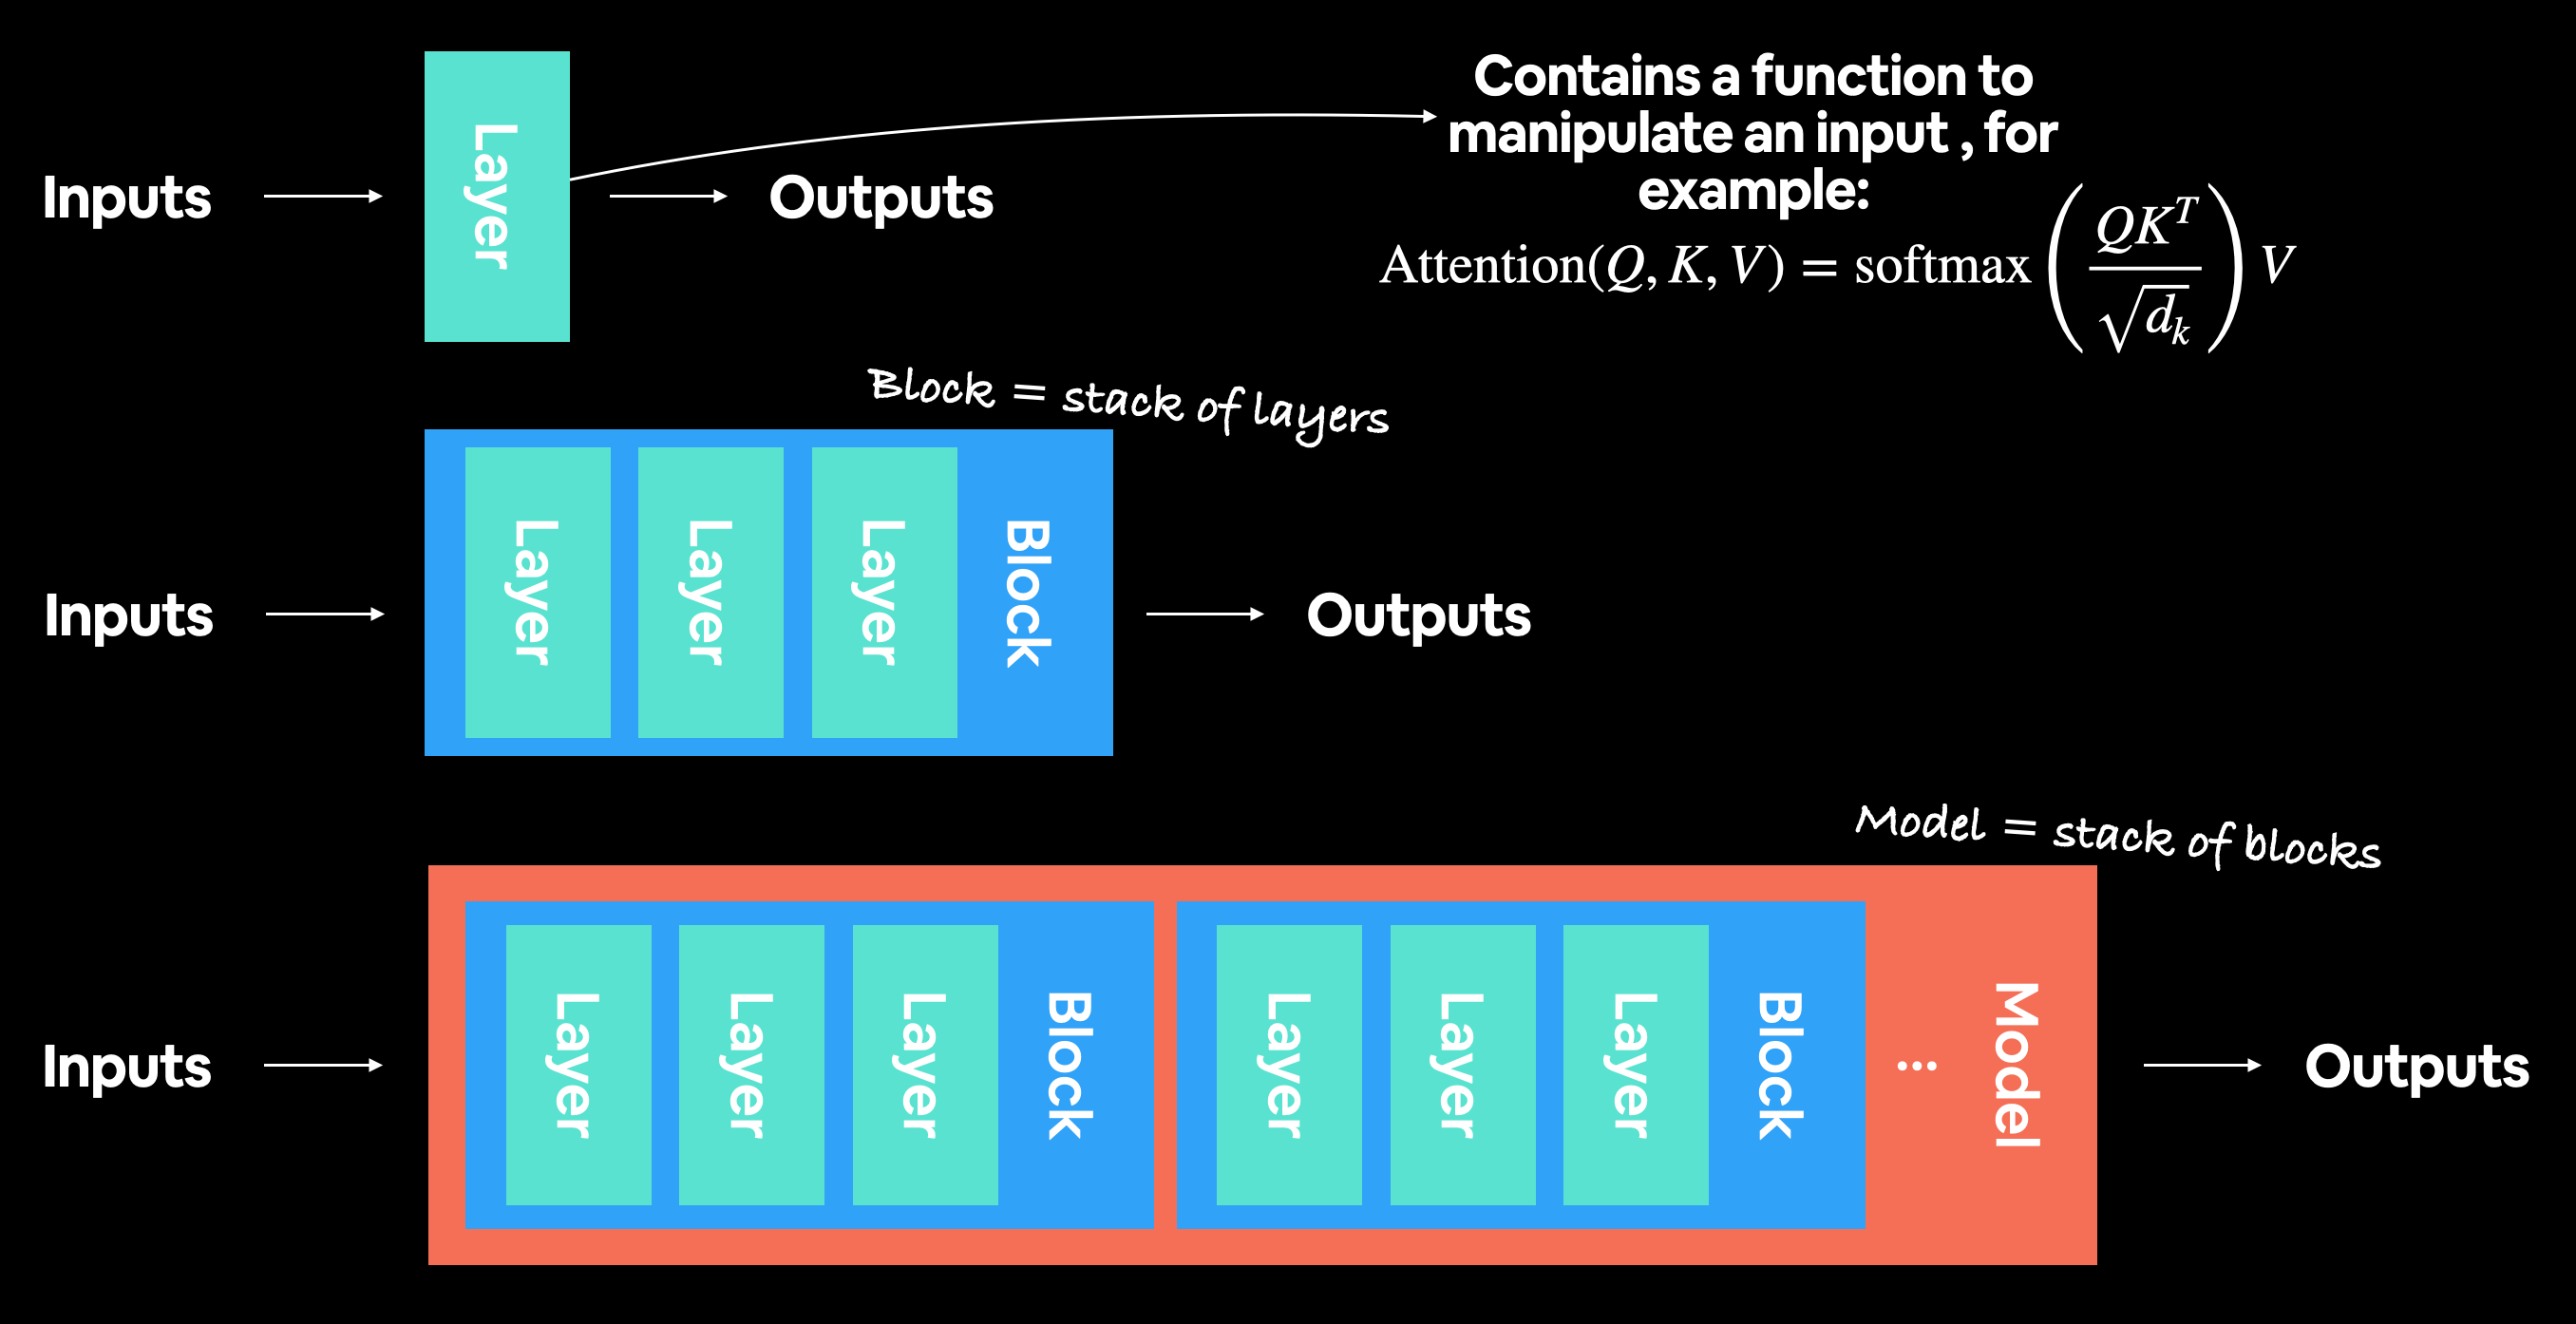
*A modern deep learning architecture is usually collection of layers and blocks. Where layers take an input (data as a numerical representation) and manipulate it using some kind of function (for example, the self-attention formula pictured above, however, this function could be almost anything) and then output it. Blocks are generally stacks of layers on top of each other doing a similar thing to a single layer but multiple times.*

### 3.2 getting specific: whats ViT made of?
Ada banyak detail kecil mengenai model ViT yang ada pada Papernya

ingat, paper penelitian sering kali merupakan hasil kerja berbulan-bulan yang di ringkas ke dalam beberapa halaman. sehingga dapat dimengerti dan jika perlu ditiru!

Namun, tiga point utama yang akan kita lihat pada desain arsitekturnya adalah:
  1. **Gambar 1**, ini memberikan gambaran umum tentang model dalam bentuk visual. kebanyakan engineer dapat membat ulang arsitektur hanya dengan gambar ini saja.
  2. **Empat persamaan pada bagian 3.1**, persamaan-persamaan ini memberikan landasan matematis pada block-block berwarna di Gambar 1.
  3. **Tabel 1**, Tabel ini menunjukkan berbagai pengaturan hyperparameter (seperti jumlah layer dan jumlah hidden units) untuk varian model ViT yang berbeda. kita akan berfokus pada versi terkecil, ViT-Base.

### 3.2.1 Exploring Gambar 1
Mari kita mulai dengan melihat Gambar 1 dari ViT Paper.

hal-hal utama yang perlu diperhatikan disini adalah:
  1. **Layers** - menerima input, melakukan operasi atau fungsi pada input, menghasilkan output
  2. **Blocks** - ialah kumpulan Layers, yang pada gilirannya juga menerima input dan menghasilkan output.
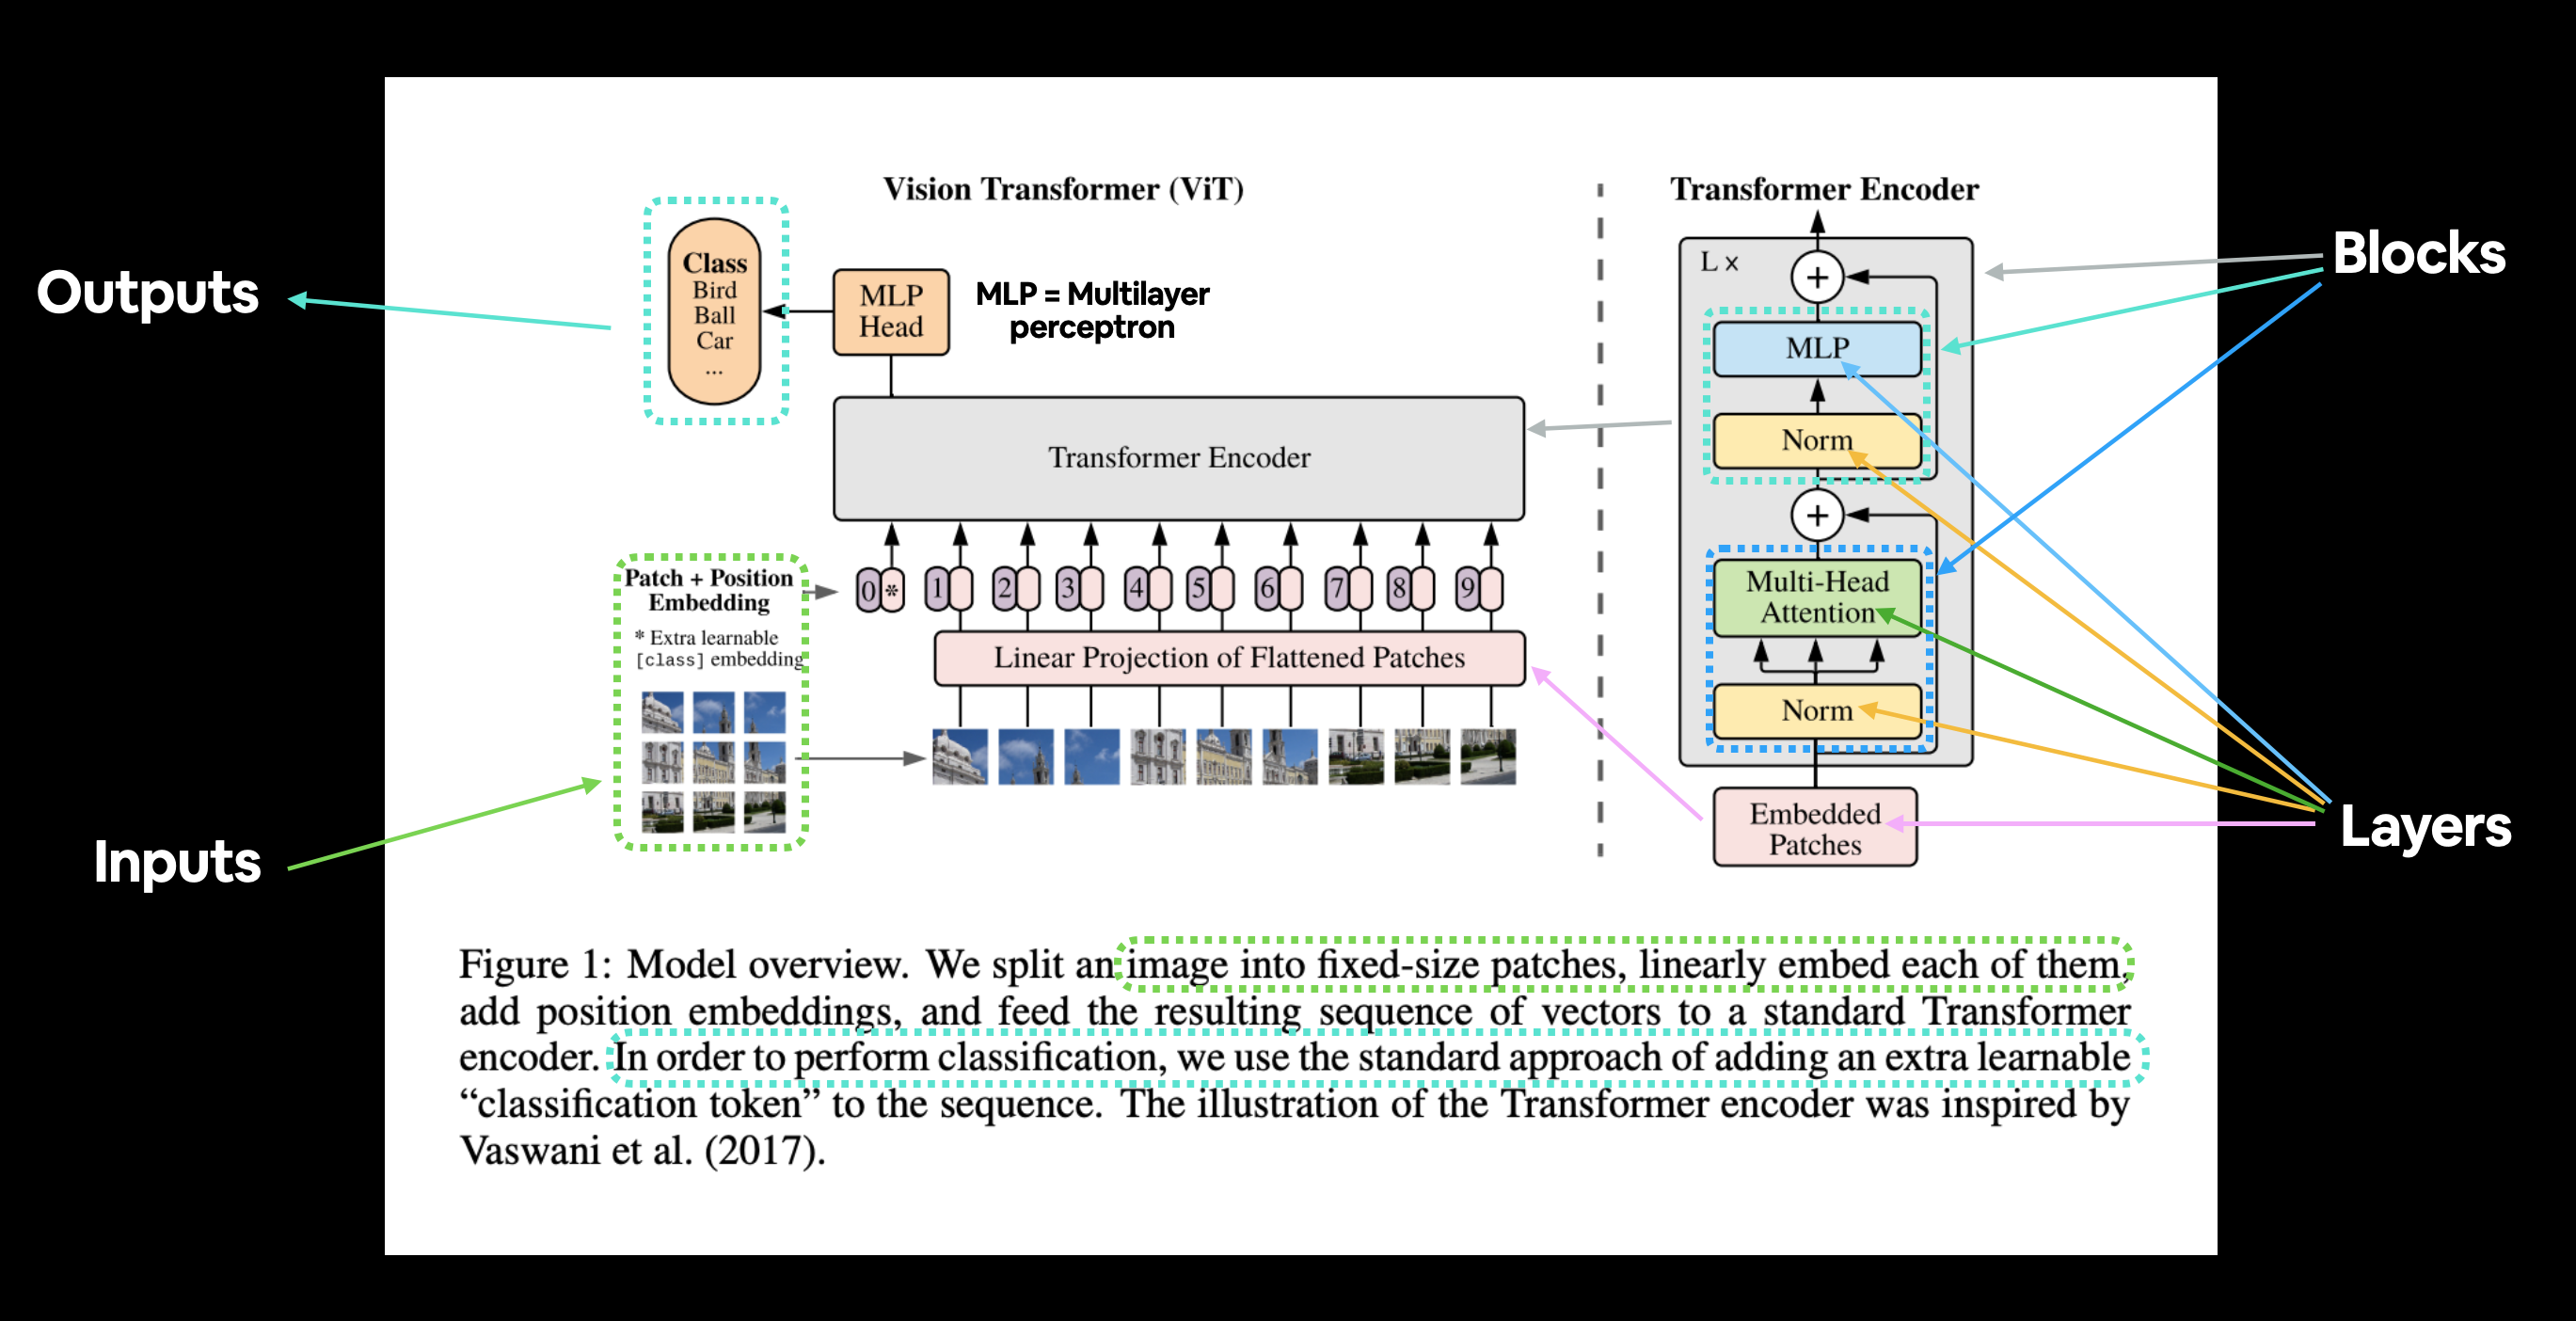 
**Figure 1 from the ViT Paper showcasing the different inputs, outputs, layers and blocks that create the architecture. Our goal will be to replicate each of these using PyTorch code.**

Arsitekrur ViT terdiri dari beberapa tahap:
 